In [1]:
import csv
import math
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import eig, inv, det
from matplotlib.patches import Ellipse
from scipy.integrate import cumtrapz
from scipy.signal import butter, filtfilt
import pandas as pd
import time
import copy

In [2]:
def quaternion_to_euler(x,y,z,w):
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    roll_x = math.degrees(math.atan2(t0, t1))
    
    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    pitch_y = math.degrees(math.asin(t2))
    
    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    yaw_z = math.degrees(math.atan2(t3, t4))
    
    return roll_x, pitch_y, yaw_z # in degrees

In [3]:
def gps_data(filepath):
	data = {"name": "not_set", "id": [], "timestamp": [], "latitude": [], "longitude": [], "altitude": [], "easting": [],
			"northing": [], "zone_code": [], "zone_number": []}

	with open(filepath, "r") as file:
		next(file)
		lines = csv.reader(file, delimiter=",")
		for i, row in enumerate(lines):
			
			data["id"].append(i)
			data["timestamp"].append(row[0])
			data["latitude"].append(float(row[5]))
			data["longitude"].append(float(row[6]))
			data["altitude"].append(float(row[7]))
			data["easting"].append(float(row[9]))
			data["northing"].append(float(row[10]))
			data["zone_code"].append(row[13])
			data["zone_number"].append(int(row[12]))

	data["timestamp"] = np.asarray(data["timestamp"])
	data["latitude"] = np.asarray(data["latitude"], dtype='float64')
	data["longitude"] = np.asarray(data["longitude"], dtype='float64')
	data["altitude"] = np.asarray(data["altitude"], dtype='float64')
	data["easting"] = np.asarray(data["easting"], dtype='float64')
	data["northing"] = np.asarray(data["northing"], dtype='float64')
	data["zone_code"] = np.asarray(data["zone_code"])
	data["zone_number"] = np.asarray(data["zone_number"], dtype='int32')

	return data

In [4]:
def imu_data(filepath):
	data = {"name": "not_set", "id": [], "timestamp": [],"seconds":[], "nanoseconds":[], "w_x": [], "w_y": [], "w_z": [], 'theta_x': [], "theta_y": [],
			"theta_z": [], "theta_w": [], "a_x": [], "a_y": [], "a_z": [], "roll":[], "pitch":[], "yaw":[]}

	with open(filepath, "r") as file:
		next(file)
		lines = csv.reader(file, delimiter=",")
		for i, row in enumerate(lines):
			r,p,y = quaternion_to_euler(float(row[9]), float(row[10]), float(row[11]),float(row[12]))
			data["id"].append(i)
			data["timestamp"].append(row[0])
			data["seconds"].append(row[2])
			data["nanoseconds"].append(row[3])
			data["roll"].append(float(r))
			data["pitch"].append(float(p))
			data["yaw"].append(float(y))

			data["w_x"].append(float(row[14]))
			data["w_y"].append(float(row[15]))
			data["w_z"].append(float(row[16]))

			data["a_x"].append(float(row[18]))
			data["a_y"].append(float(row[19]))
			data["a_z"].append(float(row[20]))

			data["theta_x"].append(float(row[9]))
			data["theta_y"].append(float(row[10]))
			data["theta_z"].append(float(row[11]))
			data["theta_w"].append(float(row[12]))


	data["timestamp"] = np.asarray(data["timestamp"])
	data["id"] = np.asarray(data["id"])
	data["seconds"] = np.asarray(data["seconds"], dtype='float64')
	data["nanoseconds"] = np.asarray(data["nanoseconds"], dtype='float64')
	data["w_x"] = np.asarray(data["w_x"], dtype='float64')
	data["w_y"] = np.asarray(data["w_y"], dtype='float64')
	data["w_z"] = np.asarray(data["w_z"], dtype='float64')
	data["a_x"] = np.asarray(data["a_x"], dtype='float64')
	data["a_y"] = np.asarray(data["a_y"], dtype='float64')
	data["a_z"] = np.asarray(data["a_z"], dtype='float64')
	data["roll"] = np.asarray(data["roll"], dtype='float64')
	data["pitch"] = np.asarray(data["pitch"], dtype='float64')
	data["yaw"] = np.asarray(data["yaw"], dtype='float64')
	data["theta_x"] = np.asarray(data["theta_x"], dtype='float64')
	data["theta_y"] = np.asarray(data["theta_y"], dtype='float64')
	data["theta_z"] = np.asarray(data["theta_z"], dtype='float64')
	data["theta_w"] = np.asarray(data["theta_w"], dtype='float64')

	return data


In [5]:
def imu_mag_data(filepath):
	data = {"name": "not_set", "id": [], "timestamp": [], "mag_x": [], "mag_y": [], "mag_z": []}

	with open(filepath, "r") as file:
		next(file)
		lines = csv.reader(file, delimiter=",")
		for i, row in enumerate(lines):
			data["id"].append(i)
			data["timestamp"].append(row[0])
			data["mag_x"].append(float(row[26]))
			data["mag_y"].append(float(row[27]))
			data["mag_z"].append(float(row[28]))

	data["timestamp"] = np.asarray(data["timestamp"])
	data["mag_x"] = np.asarray(data["mag_x"], dtype='float64')
	data["mag_y"] = np.asarray(data["mag_y"], dtype='float64')
	data["mag_z"] = np.asarray(data["mag_z"], dtype='float64')

	return data

In [6]:
def calc_ellipse_params(X, Y):
	x = X[:, np.newaxis]
	y = Y[:, np.newaxis]

	# Define the variable data points matrix
	J = np.hstack((x * x, x * y, y * y, x, y))

	K = np.ones_like(x)

	coeff_mat = inv(J.T @ J) @ J.T @ K

	coeff_mat = np.append(coeff_mat, -1)

	A_matrix = np.array(
		[
			[coeff_mat[0], coeff_mat[1] / 2.0, coeff_mat[3] / 2.0],
			[coeff_mat[1] / 2.0, coeff_mat[2]	,coeff_mat[4] / 2.0],
			[coeff_mat[3] / 2.0, coeff_mat[4] / 2.0, coeff_mat[5]]
		])

	# center of the ellipse
	A_matrix2 = A_matrix[0:2, 0:2]
	Am2Inv = inv(A_matrix2)
	offsets_ = coeff_mat[3:5] / 2.0
	center = -np.dot(Am2Inv, offsets_)

	# Center the ellipse origin
	Tofs = np.eye(3)
	Tofs[2, 0:2] = center
	R = np.dot(Tofs, np.dot(A_matrix, Tofs.T))

	R2 = R[0:2, 0:2]
	s1 = -R[2, 2]
	RS = R2 / s1
	(evals, evecs) = eig(RS)

	recip = 1.0 / np.abs(evals)
	maj_min_ax = 2*np.sqrt(recip)

	rads = np.arctan2(evecs[1, 0], evecs[0, 0])
	return (center[0], center[1], maj_min_ax[0], maj_min_ax[1], rads)

In [7]:
def calc_HI_and_SI(params):
	theta = params[4]
	sigma = params[3]/params[2]
	# Constants for rotated scaling matrix
	sin2 = np.sin(theta)**2
	cos2 = np.cos(theta)**2
	sin_cos = np.cos(theta)*np.sin(theta)
	sigma_cos = sigma*cos2
	sigma_sin = sigma*sin2
	sigma_sincos = sigma*sin_cos

	HI = {"x": params[0], "y": params[1]}
	SI = {"R": np.array([[np.cos(theta), np.sin(theta)],[-np.sin(theta), np.cos(theta)]]),
		  "scale": np.array([[sigma, 0], [0,1]]),
		  "rotated_scaling": np.array([[sigma_cos+sin2, sigma_sincos-sin_cos], [sigma_sincos-sin_cos, sigma_sin+cos2]])}

	return [HI, SI]

In [8]:
def correction(X,Y, params):
	HI, SI = params

	X = X[:, np.newaxis]
	Y = Y[:, np.newaxis]
	X = X - HI["x"]
	Y = Y - HI["y"]
	data = np.hstack((X,Y))

	print(SI["scale"]@SI["R"])
	print(HI)

	data_corrected = (inv(SI["R"]) @ SI["scale"] @ SI["R"] @ data.T).T

	return data_corrected

In [9]:
def plot_data(data=None, X=None, Y=None, name=None, ellipse=None):
	if data != None:
		X = data["easting"]
		Y = data["northing"]
		name = data["name"]

	Start_point = [X[0], Y[0]]
	End_point = [X[-1], Y[-1]]

	fig = plt.figure(figsize=(10, 8), dpi=100)
	ax = fig.add_subplot()
	ax.grid(which='major', color='#AAAAAA', linewidth=1)
	ax.grid(which='minor', color='#AAAAAA', linestyle=':', linewidth=1)
	ax.minorticks_on()
	ax.grid(True)

	if data != None:
		for i, txt in enumerate(data['id']):
			ax.annotate(txt, (X[i], Y[i] + 0.2))

	ax.plot(X, Y)
	ax.scatter(Start_point[0], Start_point[1], label="Start Point")
	ax.scatter(End_point[0], End_point[1], label="End Point")

	ax.scatter(np.mean(X), np.mean(Y), label="Mean Position Point")

	ax.set_title(name + " plot")
	ax.set_xlabel("Gauss")
	ax.set_ylabel("Gauss")
	ax.set_aspect("equal")
	if ellipse!=None:
		ax.add_patch(ellipse)


	ax.legend()
	plt.show()

In [10]:
def Mag_correction(X_mag,Y_mag,Z_mag):

	m_data = {"id": [i for i in range(len(X_mag))],
					   "mag_x": X_mag,
					   "mag_y": Y_mag,
					   "mag_z": Z_mag}

	MAG_data_circle = {"id": [i for i in range(6500 - 3500)],
					   "mag_x": m_data["mag_x"][3500:6500],
					   "mag_y": m_data["mag_y"][3500:6500],
					   "mag_z": m_data["mag_z"][3500:6500]}

	X = MAG_data_circle["mag_x"]
	Y = MAG_data_circle["mag_y"]

	# Fitting an ellipse to the data and calculate ellipse parameters
	params = calc_ellipse_params(X, Y)
	print(params)
	ellipse = Ellipse(xy=(params[0], params[1]), width=params[2], height=params[3], angle=params[4] * 180 / np.pi,
					  edgecolor='r', fc='None', lw=2, label="Best fit Ellipse")
	# Plot the result to see the best fit ellipse
	plot_data(X=X, Y=Y, name="MAG 2D plot with best fit ellipse", ellipse=ellipse)

	# Find the calibration parameters
	HI_SI = calc_HI_and_SI(params)
	MAG_data_corrected_circle = correction(X, Y, HI_SI)
	# Plot the circle trajectory data not, it should be almost circular
	plot_data(X=MAG_data_corrected_circle[:, 0], Y=MAG_data_corrected_circle[:, 1],
			  name="MAG 2D calibrated data for circular trajectory")

	corrected_mag_data = correction(m_data["mag_x"], m_data["mag_y"], HI_SI)

	m_data["mag_x"] = corrected_mag_data[:,0]
	m_data["mag_y"] = corrected_mag_data[:,1]

	return m_data, HI_SI

def butter_lowpass_filter(data, cutoff, fs, order):
	norm_cf = cutoff / (0.5*fs)

	b,a = butter(order, norm_cf, btype='low', analog=False)
	y = filtfilt(b, a, data)
	return y

def butter_highpass_filter(data, cutoff, fs, order):
	norm_cf = cutoff / (0.5*fs)
	b,a = butter(order, norm_cf, btype='high', analog=False)
	y = filtfilt(b, a, data)
	return y

def complimentary_filter(Yaw_mag, Yaw_gyro):
	Yaw_mag_fil = butter_lowpass_filter(Yaw_mag, 0.05, 40, 2)
	Yaw_gyro_fil = butter_highpass_filter(Yaw_gyro, 0.05, 40, 2)
	Yaw =  Yaw_gyro_fil + Yaw_mag_fil
	plt.plot(Yaw_mag_fil, label='LPF')
	plt.plot(Yaw_gyro_fil, label='HPF')
	plt.plot(Yaw, label='complimentary')
	plt.plot()
	plt.title("LPF vs HPF vs Complimentary filter")
	plt.xlabel("Timesteps")
	plt.ylabel("Radian")
	plt.legend()
	plt.show()
	return Yaw

def estimate_vel_GPS(data):
	X = data["easting"][200:]
	Y = data["northing"][200:]
	vel = np.zeros(X.shape)

	vel[1:] = np.sqrt((X[1:]-X[:-1])**2 + (Y[1:]-Y[:-1])**2)

	return vel


In [12]:
def comparison_plot(vars, var_names, unit, plot_mean=False, plot_rolling_mean=False, plot_stats=False):
	fig = plt.figure(figsize=(10, 8), dpi=100)
	ax = fig.add_subplot()
	ax.grid(which='major', color='#AAAAAA', linewidth=1)
	ax.grid(which='minor', color='#AAAAAA', linestyle=':', linewidth=1)
	ax.minorticks_on()
	ax.grid(True)

	for i, var in enumerate(vars):
		ax.plot(var, label=var_names[i])

	if plot_mean:
		for i, var in enumerate(vars):
			var_mean = np.mean(var) * np.ones(np.shape(var))
			ax.plot(var_mean, color='r', lw=1, label=f"Mean of {var_names[i]}")

	if plot_rolling_mean:
		for i, var in enumerate(vars):
			var_rolling_mean = pd.Series(var).rolling(window=100).mean().values
			ax.plot(var_rolling_mean, color='orange', lw=1, label=f"Rolling Mean (100 samples) of {var_names[i]}")

	if plot_stats:
		for i, var in enumerate(vars):
			var_mean = np.mean(var)
			var_std = np.std(var)
			plt.plot([], [], ' ', label=f"{var_names[i]} Mean = {var_mean}")
			plt.plot([], [], ' ', label=f"{var_names[i]} Mean = {var_std}")

	title_string = "Comparison plot for: "
	for name in var_names:
		title_string = title_string + name +", "
	ax.set_title(title_string)
	ax.set_xlabel("Timesteps")
	ax.set_ylabel(unit)

	ax.legend()
	plt.show()

def comparison_2dplot(vars, var_names, unitx, unity):
	fig = plt.figure(figsize=(10, 8), dpi=100)
	ax = fig.add_subplot()
	ax.grid(which='major', color='#AAAAAA', linewidth=1)
	ax.grid(which='minor', color='#AAAAAA', linestyle=':', linewidth=1)
	ax.minorticks_on()
	ax.grid(True)

	for i, var in enumerate(vars):
		ax.plot(var[0],var[1], label=var_names[i])

	title_string = "Comparison plot for: "
	for name in var_names:
		title_string = title_string + name + ", "
	ax.set_title(title_string)
	ax.set_xlabel(unitx)
	ax.set_ylabel(unity)

	ax.legend()
	plt.show()


In [13]:
boston_gps = gps_data("data_driving-gps.csv")
boston_imu = imu_data("data_driving-imu.csv")
boston_imu_mag = imu_mag_data("data_driving-imu.csv")

circles_gps = gps_data("data_going_in_circles-gps.csv")
circles_imu = imu_data("data_going_in_circles-imu.csv")
circles_imu_mag = imu_mag_data("data_going_in_circles-imu.csv")

circles_imu_mag['name'] = "MAG"
boston_gps['name'] = "GPS"
boston_imu['name'] = "IMU"
boston_imu_mag['name'] = "MAG"

(0.05778209908687602, 0.21744583827422928, 0.14628291487085268, 0.11353423199989397, -2.9213295352390243)


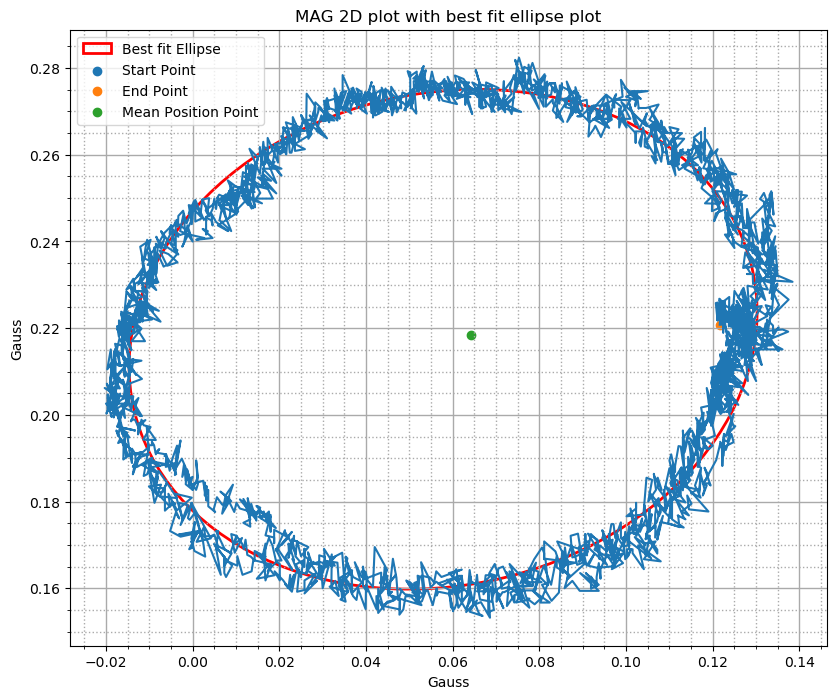

[[-0.75737652 -0.16957336]
 [ 0.21848639 -0.97584   ]]
{'x': 0.05778209908687602, 'y': 0.21744583827422928}


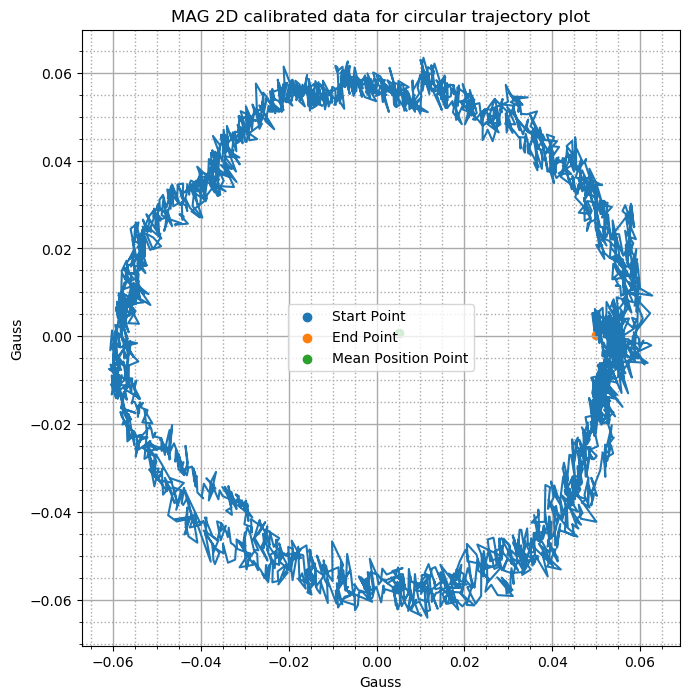

[[-0.75737652 -0.16957336]
 [ 0.21848639 -0.97584   ]]
{'x': 0.05778209908687602, 'y': 0.21744583827422928}


In [14]:
m_x = copy.copy(circles_imu_mag["mag_x"])
m_y = copy.copy(circles_imu_mag["mag_y"])
m_z = copy.copy(circles_imu_mag["mag_z"])
MAG_data, params = Mag_correction(m_x,m_y,m_z, verbose=True)

# Sensor Fusion

In [15]:
mb_x = copy.copy(boston_imu_mag["mag_x"])
mb_y = copy.copy(boston_imu_mag["mag_y"])
mb_z = copy.copy(boston_imu_mag["mag_z"])
MAG_data_boston = correction(mb_x,mb_y,params)

[[-0.75737652 -0.16957336]
 [ 0.21848639 -0.97584   ]]
{'x': 0.05778209908687602, 'y': 0.21744583827422928}


In [16]:
Yaw_mag_corr = np.arctan2(MAG_data_boston[:,1][8000:],MAG_data_boston[:,0][8000:])

In [17]:
Yaw_mag_raw = np.arctan2(boston_imu_mag["mag_y"][8000:],boston_imu_mag["mag_x"][8000:])

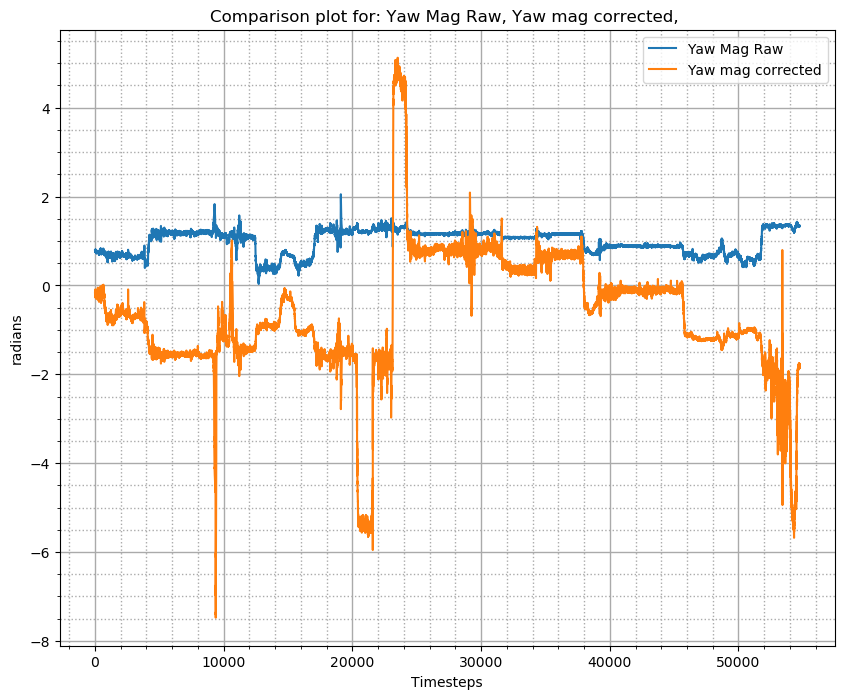

In [18]:
comparison_plot([np.unwrap(Yaw_mag_raw), np.unwrap(Yaw_mag_corr)], ["Yaw Mag Raw", "Yaw mag corrected"], "radians")

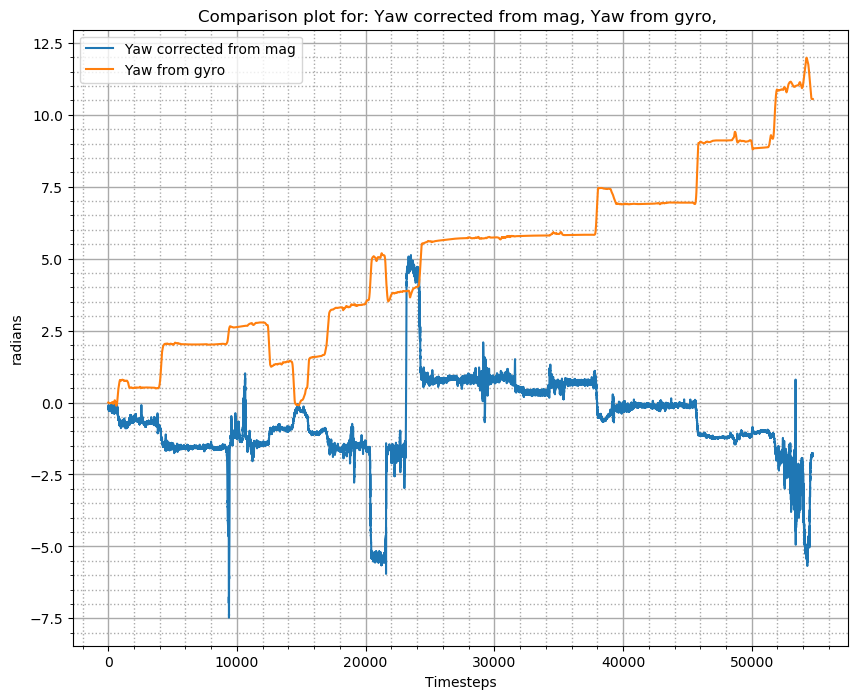

In [19]:
# Step 3: Calculate Yaw angle by integrating Yaw rate
Yaw_gyro = cumtrapz(boston_imu["w_z"][8000:], initial=0, dx=0.025)


# Step 4: Compare Yaw_mag and Yaw_gyro
comparison_plot([np.unwrap(Yaw_mag_corr), np.unwrap(Yaw_gyro)], ["Yaw corrected from mag", "Yaw from gyro"], "radians")


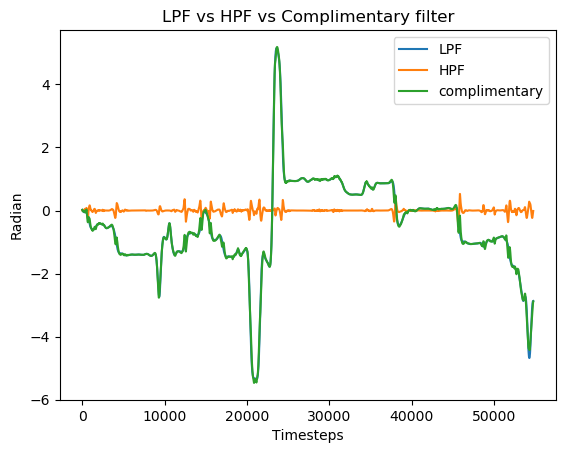

/home/ubuntu20_04/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


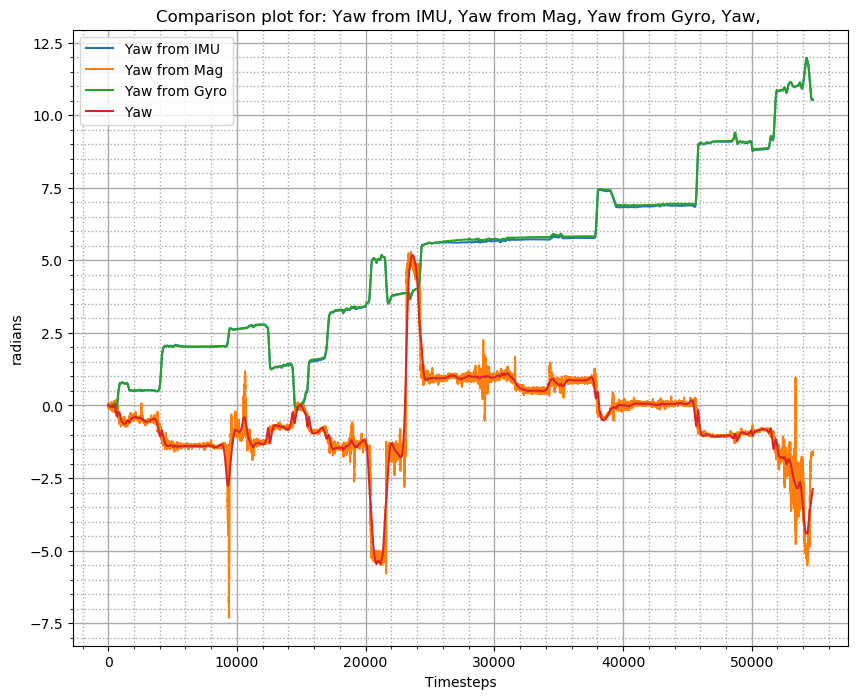

In [20]:
Yaw = complimentary_filter(np.unwrap(Yaw_mag_corr-Yaw_mag_corr[0]),np.unwrap(Yaw_gyro-Yaw_gyro[0]))
	#
	# # Step 6: Compare against yaw angle from IMU
Yaw_Imu = boston_imu["yaw"][8000:]*(np.pi/180)# Convert degree to radian
comparison_plot([np.unwrap(Yaw_Imu)-Yaw_Imu[0], np.unwrap(Yaw_mag_corr-Yaw_mag_corr[0]), np.unwrap(Yaw_gyro-Yaw_gyro[0]), Yaw],
			 ["Yaw from IMU", "Yaw from Mag", "Yaw from Gyro", "Yaw"], "radians")

In [21]:
linear_acc = boston_imu["a_x"]

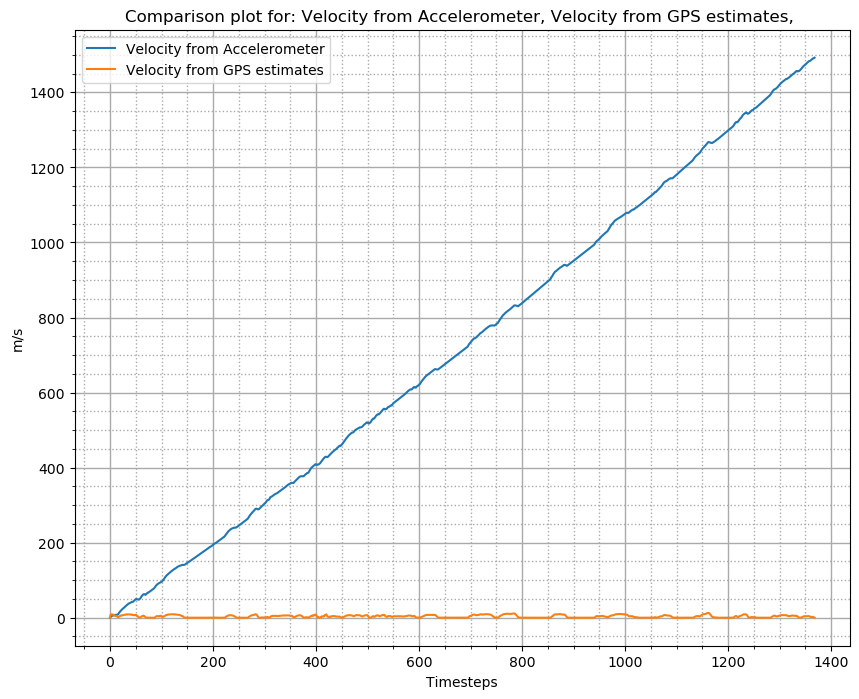

In [22]:
# # Step 7: Integrate the forward acceleration to estimate forward velocity
v_accel = cumtrapz(linear_acc[8000:], initial=0, dx=0.025)[::40]


# # Step 8: Calculate velocity estimate from GPS
v_gps = estimate_vel_GPS(boston_gps)
	#
	# # Step 9: Compare both velocity estimates
comparison_plot([v_accel, v_gps], ["Velocity from Accelerometer", "Velocity from GPS estimates"], "m/s")

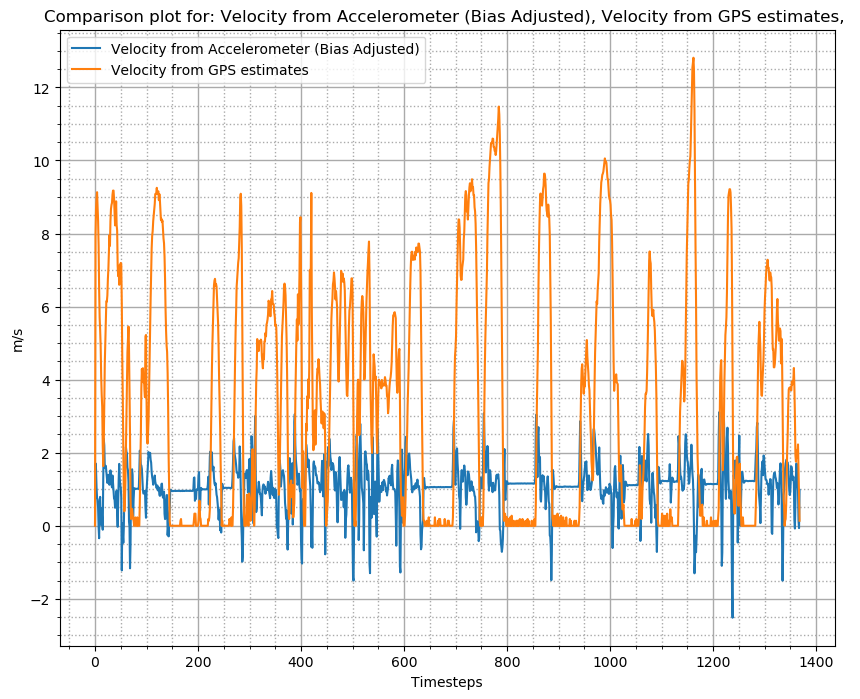

In [23]:
v_accel_fil = copy.copy(v_accel)
# Initialize variables
WINDOW_SIZE = 4000  # Size of rolling window for bias estimation
THRESHOLD = 0.1 
bias = 0
window_start = 0
window_end = 0
window_mean = 0

# Loop through the acceleration data and estimate the bias
for i in range(len(v_accel_fil)):
    # Update the rolling window
    if i >= window_end:
        window_start = i
        window_end = i + WINDOW_SIZE
        window_mean = np.mean(v_accel_fil[window_start:window_end], axis=0)
    
    # Check if the acceleration is close to the known value
    if np.linalg.norm(v_accel_fil[i] - window_mean) > THRESHOLD:
        # Estimate the bias and subtract from all future values
        bias = (bias*i + v_accel_fil[i]*(WINDOW_SIZE//2))/(i+(WINDOW_SIZE//2))
        v_accel_fil[i+1:] -= bias

comparison_plot([v_accel_fil, v_gps], ["Velocity from Accelerometer (Bias Adjusted)", "Velocity from GPS estimates"], "m/s")
	#

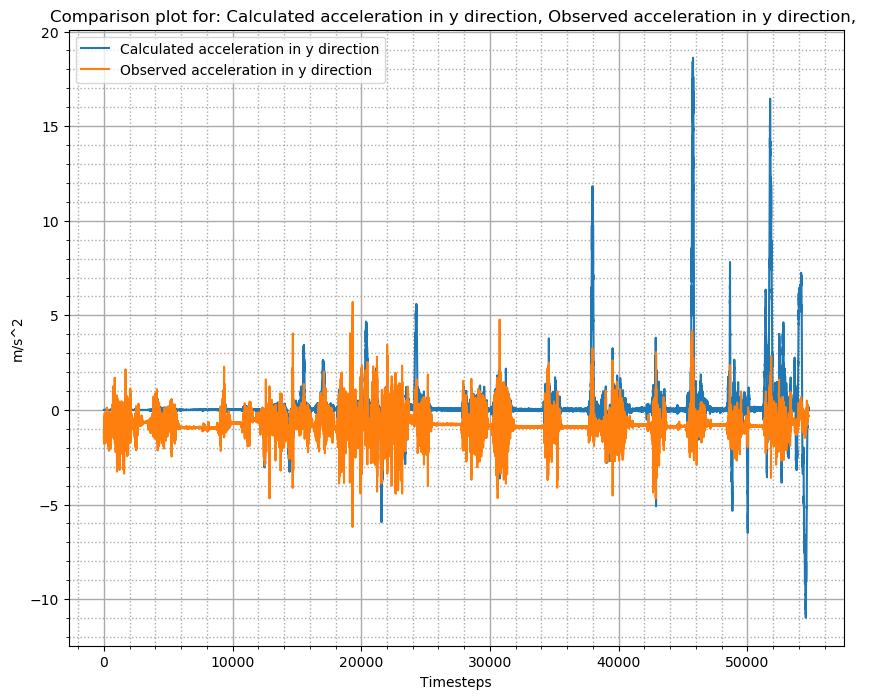

In [24]:
# # Step 11: Integrate IMU data to obtain displacement
X_dot = cumtrapz(boston_imu["a_x"][8000:]- np.mean(boston_imu["a_x"][:350]), initial=0, dx=0.025)/10
w_X_dot = boston_imu["w_z"][8000:]*X_dot
comparison_plot([w_X_dot, boston_imu["a_y"][8000:]], ["Calculated acceleration in y direction", "Observed acceleration in y direction"], "m/s^2")

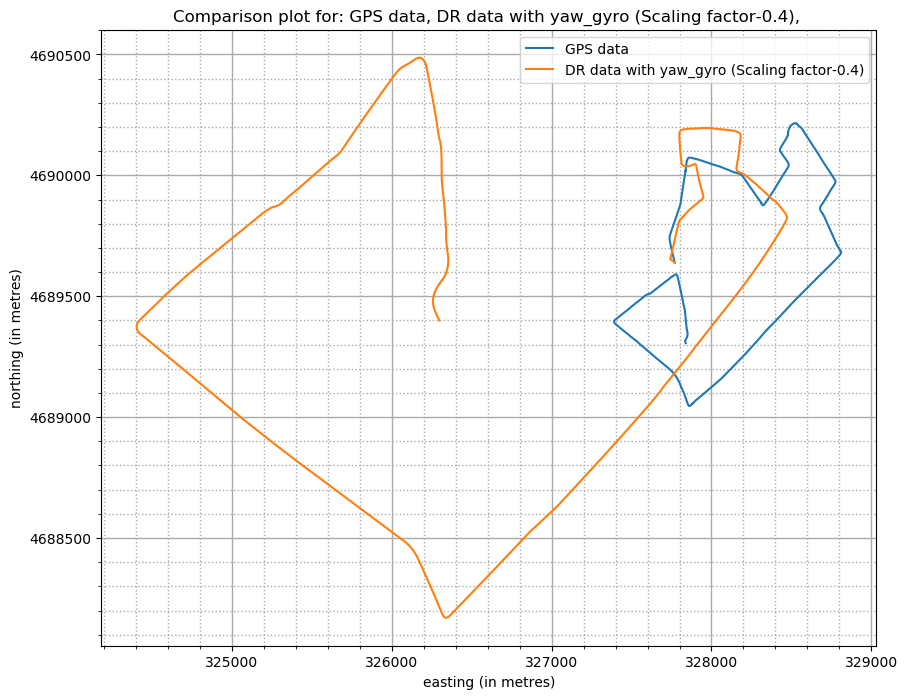

In [25]:
# Step 12: Compare displacement with GPS
acc_x = (boston_imu["a_x"][8000:]- np.mean(boston_imu["a_x"][:350]))/10
acc_y = w_X_dot

theta = Yaw_Imu-0.6*np.pi/2
a_total_x = acc_x*np.sin(theta) + acc_y*np.cos(theta)
a_total_y = acc_x*np.cos(theta) - acc_y*np.sin(theta)



calcuated_x = cumtrapz(cumtrapz((a_total_x), initial=0, dx=0.025), initial=0, dx=0.025)
calculated_y = cumtrapz(cumtrapz((a_total_y), initial=0, dx=0.025), initial=0, dx=0.025)

theta2 = Yaw_mag_corr
a_total_x2 = acc_x * np.sin(theta2) + acc_y * np.cos(theta2)
a_total_y2 = acc_x * np.cos(theta2) - acc_y * np.sin(theta2)

x_calc2 = cumtrapz(cumtrapz((a_total_x2), initial=0, dx=0.025), initial=0, dx=0.025)
calculated_y2 = cumtrapz(cumtrapz((a_total_y2), initial=0, dx=0.025), initial=0, dx=0.025)

x_gps = boston_gps["easting"][200:]
y_gps = boston_gps["northing"][200:]

a = 0.4
comparison_2dplot([[x_gps, y_gps], [a*calcuated_x+x_gps[0], a*calculated_y+y_gps[0]]],
                ["GPS data",f"DR data with yaw_gyro (Scaling factor-{a})"],
                "easting (in metres)", "northing (in metres)")


In [26]:
X_dot = cumtrapz(boston_imu["a_x"][34950:39950]- np.mean(boston_imu["a_x"][:350]), initial=0, dx=0.025)
w_X_dot = boston_imu["w_z"][34950:39950] * X_dot

# Step 13: Estimate x_c
w = boston_imu["w_z"][34950:39950]
w_dot = (w[1:]-w[:-1])/0.025
x_c = np.mean((boston_imu["a_y"][34951:39950]- np.mean(boston_imu["a_y"][:350])-w_X_dot[1:5000])/(w_dot), where=w_dot!=0)

print("x_c => ", x_c)

x_c =>  1.1510329230457481


/tmp/ipykernel_199987/392706697.py:7: RuntimeWarning: divide by zero encountered in divide
  x_c = np.mean((boston_imu["a_y"][34951:39950]- np.mean(boston_imu["a_y"][:350])-w_X_dot[1:5000])/(w_dot), where=w_dot!=0)
